# 04 - Model Evaluation

This notebook evaluates the trained ResNet18-LSTM model on the final test set.  
We compute accuracy and show the confusion matrix for MI vs. non-MI classification.

The model used was trained on A4C frames using 16 frames per video.


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
from myutils import denormalize, get_frames, store_frames

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
import pickle

with open("./a4c_video_splits.pkl", "rb") as f:
    splits = pickle.load(f)

test_videos = splits["final_test_videos"]
test_labels = splits["final_test_labels"]


In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
timesteps = 16
view = "A4C" # Change to "A2C" to evaluate the A2C model instead


eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, ids, labels, transform, split="test"):
        self.ids = ids
        self.labels = labels
        self.transform = transform
        self.folder_map = {
            "test": f"{view}_jpg_test"
        }
        self.timesteps = timesteps
        self.split = split

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        base_path = self.ids[idx].replace(view, self.folder_map[self.split]).replace(".avi", "")
        frame_paths = sorted(glob(os.path.join(base_path, "*.jpg")))[:self.timesteps]
        frames = [self.transform(Image.open(p).convert("RGB")) for p in frame_paths]
        return torch.stack(frames), self.labels[idx]

def collate_fn(batch):
    xb, yb = zip(*batch)
    return torch.stack(xb), torch.tensor(yb)

test_ds = VideoDataset(test_videos, test_labels, eval_transform, "test")
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Identity(nn.Module):
    def forward(self, x):
        return x

class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super().__init__()
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.resnet18(weights="IMAGENET1K_V1")
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.rnn = nn.LSTM(512, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.dropout = nn.Dropout(dr_rate)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

        self.attn = nn.Linear(rnn_hidden_size * 2, rnn_hidden_size)
        self.v = nn.Linear(rnn_hidden_size, 1, bias=False)

    def forward(self, x):
        b, t, c, h, w = x.shape
        outputs = []

        y = self.baseModel(x[:, 0])
        rnn_out, (hn, cn) = self.rnn(y.unsqueeze(1))
        outputs.append(rnn_out)

        for i in range(1, t):
            y = self.baseModel(x[:, i])
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)
        query = self.dropout(out[:, -1])
        hidden = query.unsqueeze(1).repeat(1, outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, outputs), dim=2)))
        attention = F.softmax(self.v(energy).squeeze(2), dim=1)
        weighted = torch.bmm(attention.unsqueeze(1), outputs).squeeze(1)
        return self.fc1(weighted)


In [13]:


params_model = {
    "num_classes": 2,
    "dr_rate": 0.3,
    "rnn_hidden_size": 100,
    "rnn_num_layers": 1
}

model = Resnt18Rnn(params_model)
model.load_state_dict(torch.load("../models/weights_a4c_rnn.pt", map_location=device)) # Change path for A2C if needed
model.to(device).eval()


Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [14]:
def evaluate_model_with_probs(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)


In [15]:
def plot_roc_curve(probabilities, true_labels):
    pos_probs = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, pos_probs)
    roc_auc = auc(fpr, tpr)

    # Youden’s Index
    sensitivity = tpr
    specificity = 1 - fpr
    youden = (sensitivity + specificity - 1) / np.sqrt(2)
    opt_idx = np.argmax(youden)
    opt_thresh = thresholds[opt_idx]

    preds = (pos_probs >= opt_thresh).astype(int)
    cm = confusion_matrix(true_labels, preds)
    tn, fp, fn, tp = cm.ravel()

    print("\nConfusion Matrix Statistics:")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Sensitivity: {tp / (tp + fn):.3f}")
    print(f"Specificity: {tn / (tn + fp):.3f}")
    print(f"Accuracy: {(tp + tn) / len(true_labels):.3f}")
    print(f"AUC: {roc_auc:.3f}")
    print(f"Optimal Threshold: {opt_thresh:.3f} (Youden Index)")

    # Plot ROC
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="blue")
    plt.scatter(fpr[opt_idx], tpr[opt_idx], color='red', marker='x', label="Optimal Threshold")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title("ROC Curve — A4C Test Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Non-MI", "MI"], yticklabels=["Non-MI", "MI"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix — A4C Test Set")
    plt.tight_layout()
    plt.show()



Confusion Matrix Statistics:
TP: 6, TN: 5, FP: 0, FN: 2
Sensitivity: 0.750
Specificity: 1.000
Accuracy: 0.846
AUC: 0.900
Optimal Threshold: 0.802 (Youden Index)


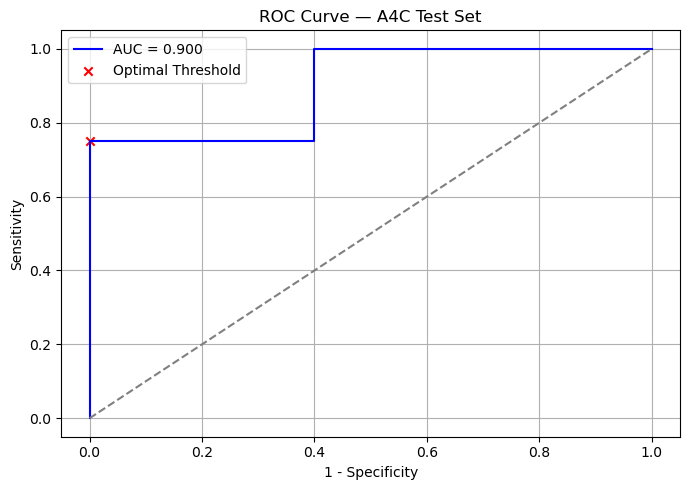

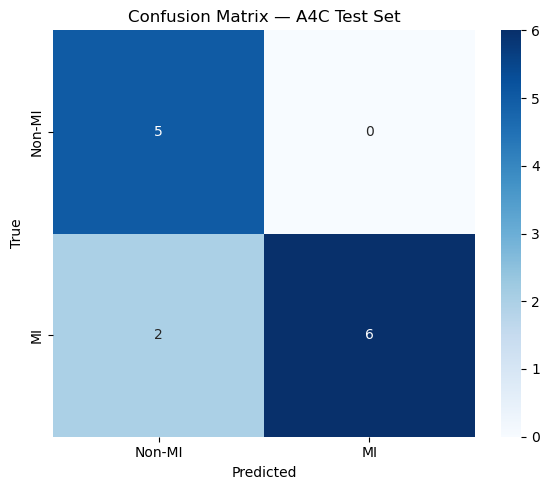

In [16]:
probs, labels = evaluate_model_with_probs(model, test_dl, device)
plot_roc_curve(probs, labels)
